# Comprehensive Model Comparison

This notebook provides a thorough comparison of multiple classification models for predicting prolonged ICU stays.

## Models Evaluated:
1. Logistic Regression
2. Random Forest
3. Gradient Boosting
4. SGD Classifier

## Evaluation Strategy:
- 60/20/20 train/validation/test split
- Validation set for hyperparameter tuning
- Test set for final held-out evaluation
- Overfitting detection via train vs test metrics
- ROC curves, confusion matrices, feature importance

In [1]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, roc_auc_score
)
from time import perf_counter

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
# Load data from DuckDB
conn = duckdb.connect("../../data/duckdb/fedlearn.duckdb")
df = conn.execute("select * from v_features_icu_stay_clean").df()

# Normalize pandas.NA -> np.nan
df = df.where(df.notna(), np.nan)

print(f"Total samples: {len(df):,}")
print(f"Features: {len(df.columns)}")
print(f"\nTarget distribution:")
print(df['prolonged_stay'].value_counts())
print(f"\nClass balance: {df['prolonged_stay'].value_counts(normalize=True)}")

Total samples: 199,646
Features: 103

Target distribution:
prolonged_stay
0    150206
1     49440
Name: count, dtype: int64

Class balance: prolonged_stay
0    0.752362
1    0.247638
Name: proportion, dtype: float64


## 2. Preprocessing Pipeline

In [3]:
def build_preprocessor(df_features):
    """Build preprocessing pipeline with imputation and scaling."""
    numeric_features = df_features.select_dtypes(include=["number"]).columns
    categorical_features = df_features.select_dtypes(exclude=["number"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", numeric_transformer, numeric_features),
            ("categorical", categorical_transformer, categorical_features),
        ],
    )

    return preprocessor

# Prepare features and target
y = df["prolonged_stay"]
X = df.drop(columns=["patientunitstayid", "los_days", "prolonged_stay", "apacheadmissiondx"])

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Feature matrix shape: (199646, 99)
Target shape: (199646,)


## 3. Train/Validation/Test Split (60/20/20)

In [4]:
# First split: 80/20 (train+val / test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75/25 of remaining (60/20 of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Dataset split sizes:")
print(f"  Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

Dataset split sizes:
  Training:   119,787 samples (60.0%)
  Validation: 39,929 samples (20.0%)
  Test:       39,930 samples (20.0%)


## 4. Define Models

In [5]:
# Build preprocessor
preprocessor = build_preprocessor(X)

# Define models
models = {
    "Logistic Regression": Pipeline([
        ("preprocessor", build_preprocessor(X)),
        ("classifier", LogisticRegression(
            max_iter=1000,
            n_jobs=-1,
            class_weight="balanced",
            solver="lbfgs",
            random_state=42,
        )),
    ]),
    
    "Random Forest": Pipeline([
        ("preprocessor", build_preprocessor(X)),
        ("classifier", RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
        )),
    ]),
    
    "Gradient Boosting": Pipeline([
        ("preprocessor", build_preprocessor(X)),
        ("classifier", GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42,
        )),
    ]),
    
    "SGD Classifier": Pipeline([
        ("preprocessor", build_preprocessor(X)),
        ("classifier", SGDClassifier(
            loss="log_loss",
            penalty="l2",
            alpha=0.0001,
            max_iter=1000,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
        )),
    ]),
}

print(f"Number of models: {len(models)}")

Number of models: 4


## 5. Train and Evaluate Models

In [6]:
# Store results
results = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training {name}...")
    print('='*80)
    
    # Train
    t0 = perf_counter()
    model.fit(X_train, y_train)
    train_time = perf_counter() - t0
    
    # Predict on all sets
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Get probabilities for ROC curve
    if hasattr(model.named_steps['classifier'], 'predict_proba'):
        y_prob_train = model.predict_proba(X_train)[:, 1]
        y_prob_val = model.predict_proba(X_val)[:, 1]
        y_prob_test = model.predict_proba(X_test)[:, 1]
    else:
        # SGDClassifier uses decision_function
        y_prob_train = model.decision_function(X_train)
        y_prob_val = model.decision_function(X_val)
        y_prob_test = model.decision_function(X_test)
    
    # Compute metrics for each set
    def compute_metrics(y_true, y_pred, y_prob):
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0
        )
        roc_auc = roc_auc_score(y_true, y_prob)
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc_auc,
        }
    
    train_metrics = compute_metrics(y_train, y_pred_train, y_prob_train)
    val_metrics = compute_metrics(y_val, y_pred_val, y_prob_val)
    test_metrics = compute_metrics(y_test, y_pred_test, y_prob_test)
    
    # Store results
    results[name] = {
        'model': model,
        'train_time': train_time,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'y_pred_train': y_pred_train,
        'y_pred_val': y_pred_val,
        'y_pred_test': y_pred_test,
        'y_prob_train': y_prob_train,
        'y_prob_val': y_prob_val,
        'y_prob_test': y_prob_test,
    }
    
    # Print results
    print(f"\nTrain time: {train_time:.3f}s")
    print("\nTrain metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric:12s}: {value:.4f}")
    print("\nValidation metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric:12s}: {value:.4f}")
    print("\nTest metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric:12s}: {value:.4f}")
    
    # Overfitting detection
    train_test_gap = train_metrics['f1'] - test_metrics['f1']
    print(f"\nOverfitting gap (train F1 - test F1): {train_test_gap:.4f}")
    if train_test_gap > 0.1:
        print("  ⚠️  WARNING: Significant overfitting detected")

print("\n" + "="*80)
print("All models trained successfully!")
print("="*80)


Training Logistic Regression...


/home/jamieontiveros/Development/university_michigan/ari510capstone-fedlearn/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train time: 26.815s

Train metrics:
  accuracy    : 0.7159
  precision   : 0.6607
  recall      : 0.7008
  f1          : 0.6669
  roc_auc     : 0.7712

Validation metrics:
  accuracy    : 0.7181
  precision   : 0.6622
  recall      : 0.7021
  f1          : 0.6688
  roc_auc     : 0.7707

Test metrics:
  accuracy    : 0.7166
  precision   : 0.6600
  recall      : 0.6989
  f1          : 0.6664
  roc_auc     : 0.7711

Overfitting gap (train F1 - test F1): 0.0005

Training Random Forest...

Train time: 5.397s

Train metrics:
  accuracy    : 0.7567
  precision   : 0.6973
  recall      : 0.7391
  f1          : 0.7081
  roc_auc     : 0.8154

Validation metrics:
  accuracy    : 0.7373
  precision   : 0.6763
  recall      : 0.7142
  f1          : 0.6854
  roc_auc     : 0.7876

Test metrics:
  accuracy    : 0.7383
  precision   : 0.6770
  recall      : 0.7147
  f1          : 0.6862
  roc_auc     : 0.7877

Overfitting gap (train F1 - test F1): 0.0219

Training Gradient Boosting...

Train time: 14

## 6. Model Comparison Summary

In [7]:
# Create comparison DataFrame
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Train Time (s)': res['train_time'],
        'Train F1': res['train_metrics']['f1'],
        'Val F1': res['val_metrics']['f1'],
        'Test F1': res['test_metrics']['f1'],
        'Train ROC-AUC': res['train_metrics']['roc_auc'],
        'Val ROC-AUC': res['val_metrics']['roc_auc'],
        'Test ROC-AUC': res['test_metrics']['roc_auc'],
        'Overfit Gap': res['train_metrics']['f1'] - res['test_metrics']['f1'],
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test F1', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


MODEL COMPARISON SUMMARY
              Model  Train Time (s)  Train F1   Val F1  Test F1  Train ROC-AUC  Val ROC-AUC  Test ROC-AUC  Overfit Gap
      Random Forest        5.396737  0.708120 0.685385 0.686185       0.815406     0.787573      0.787653     0.021935
  Gradient Boosting      144.916550  0.703522 0.685425 0.680918       0.828407     0.808739      0.806026     0.022604
Logistic Regression       26.815019  0.666897 0.668754 0.666423       0.771154     0.770700      0.771063     0.000474
     SGD Classifier        4.092313  0.561666 0.566663 0.564394       0.575099     0.583085      0.580295    -0.002728


## 7. Overfitting Detection Visualization

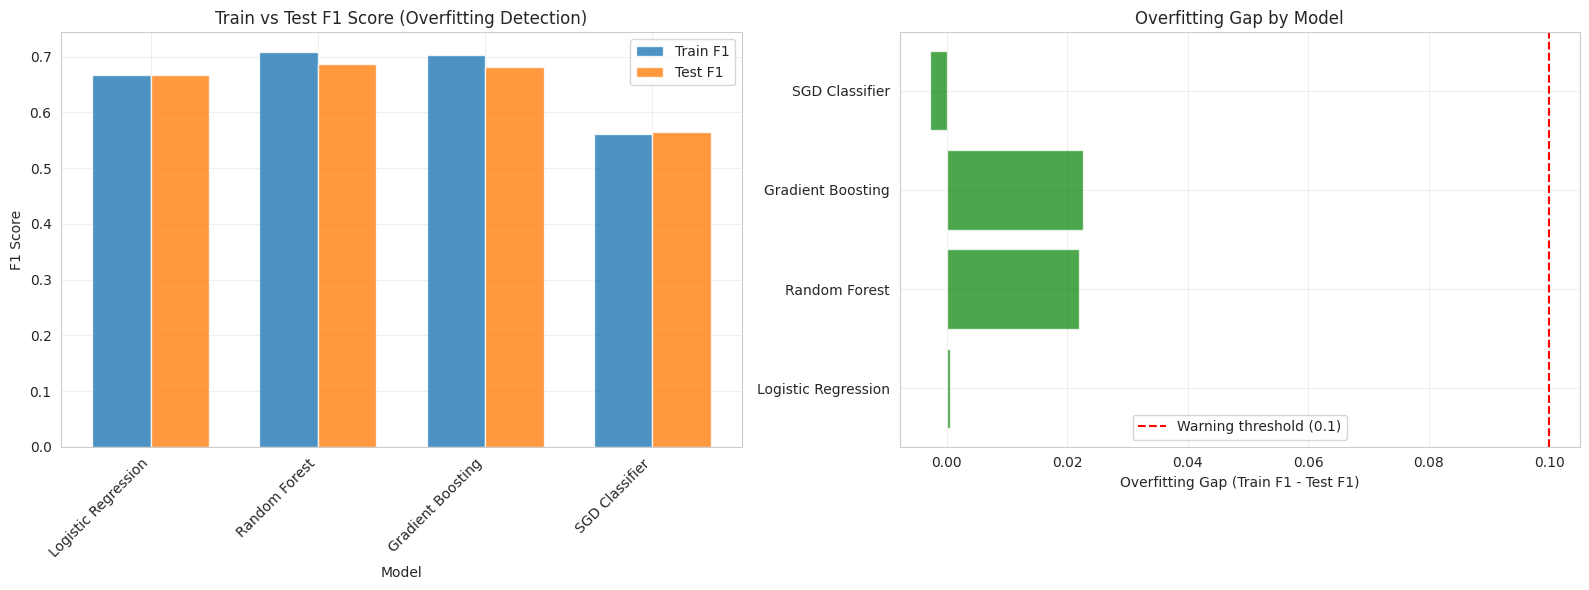

In [8]:
# Train vs Test F1 Score comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Train vs Test F1
x_pos = np.arange(len(results))
train_f1 = [res['train_metrics']['f1'] for res in results.values()]
test_f1 = [res['test_metrics']['f1'] for res in results.values()]
model_names = list(results.keys())

width = 0.35
ax1.bar(x_pos - width/2, train_f1, width, label='Train F1', alpha=0.8)
ax1.bar(x_pos + width/2, test_f1, width, label='Test F1', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('F1 Score')
ax1.set_title('Train vs Test F1 Score (Overfitting Detection)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Overfitting Gap
overfit_gaps = [res['train_metrics']['f1'] - res['test_metrics']['f1'] for res in results.values()]
colors = ['red' if gap > 0.1 else 'green' for gap in overfit_gaps]
ax2.barh(model_names, overfit_gaps, color=colors, alpha=0.7)
ax2.axvline(x=0.1, color='red', linestyle='--', label='Warning threshold (0.1)')
ax2.set_xlabel('Overfitting Gap (Train F1 - Test F1)')
ax2.set_title('Overfitting Gap by Model')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. ROC Curves

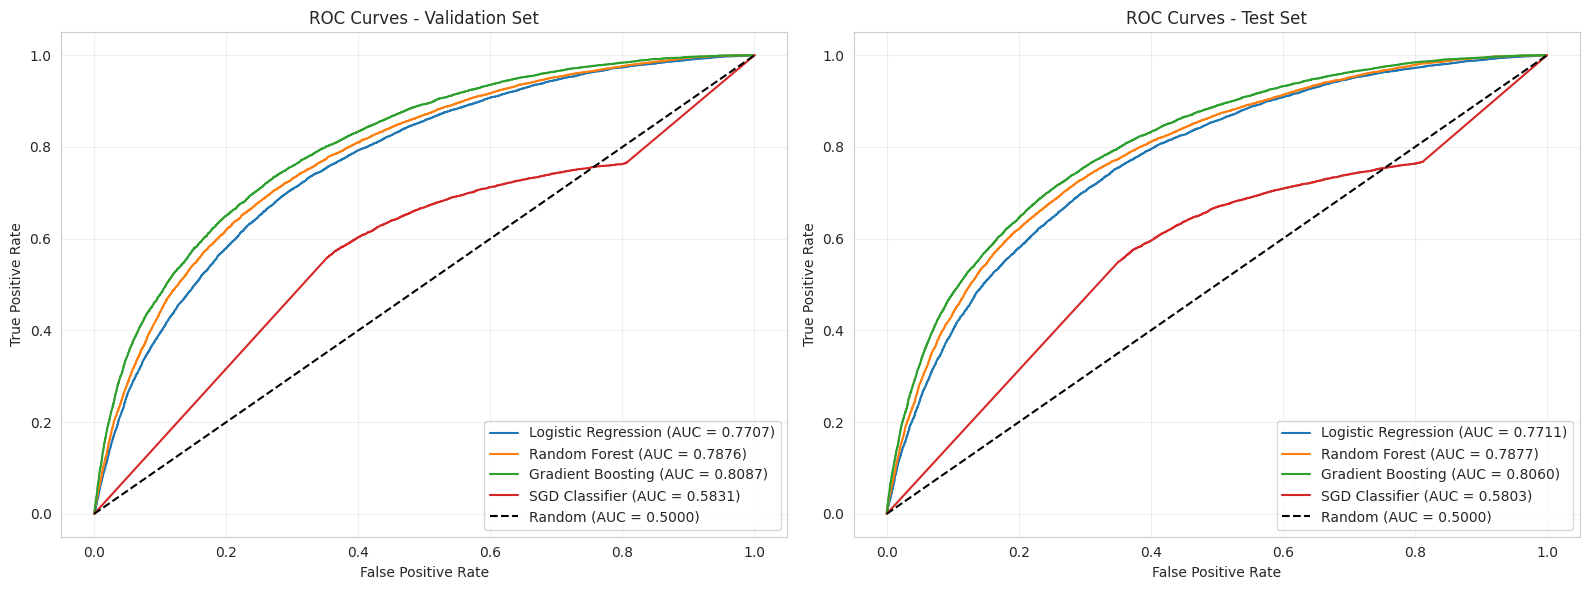

In [9]:
# Plot ROC curves for all models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation set ROC
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_val, res['y_prob_val'])
    roc_auc = res['val_metrics']['roc_auc']
    ax1.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - Validation Set')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Test set ROC
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob_test'])
    roc_auc = res['test_metrics']['roc_auc']
    ax2.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

ax2.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves - Test Set')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Confusion Matrices

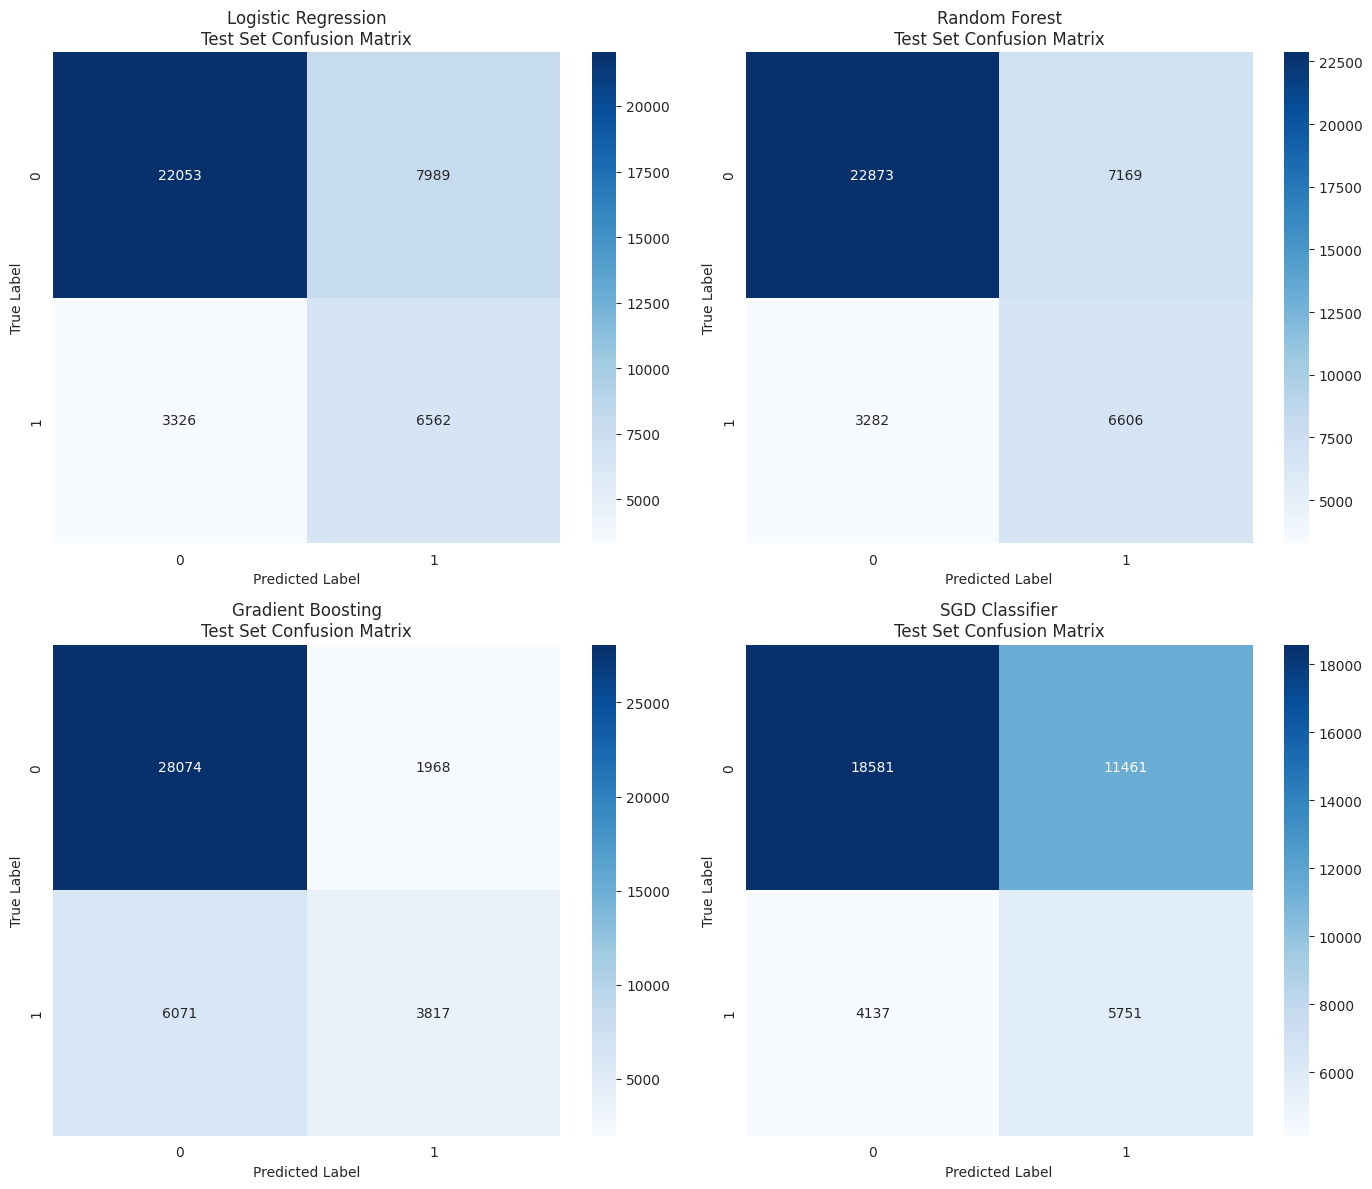

In [10]:
# Plot confusion matrices for test set
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred_test'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\nTest Set Confusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 10. Feature Importance (Tree-based Models)

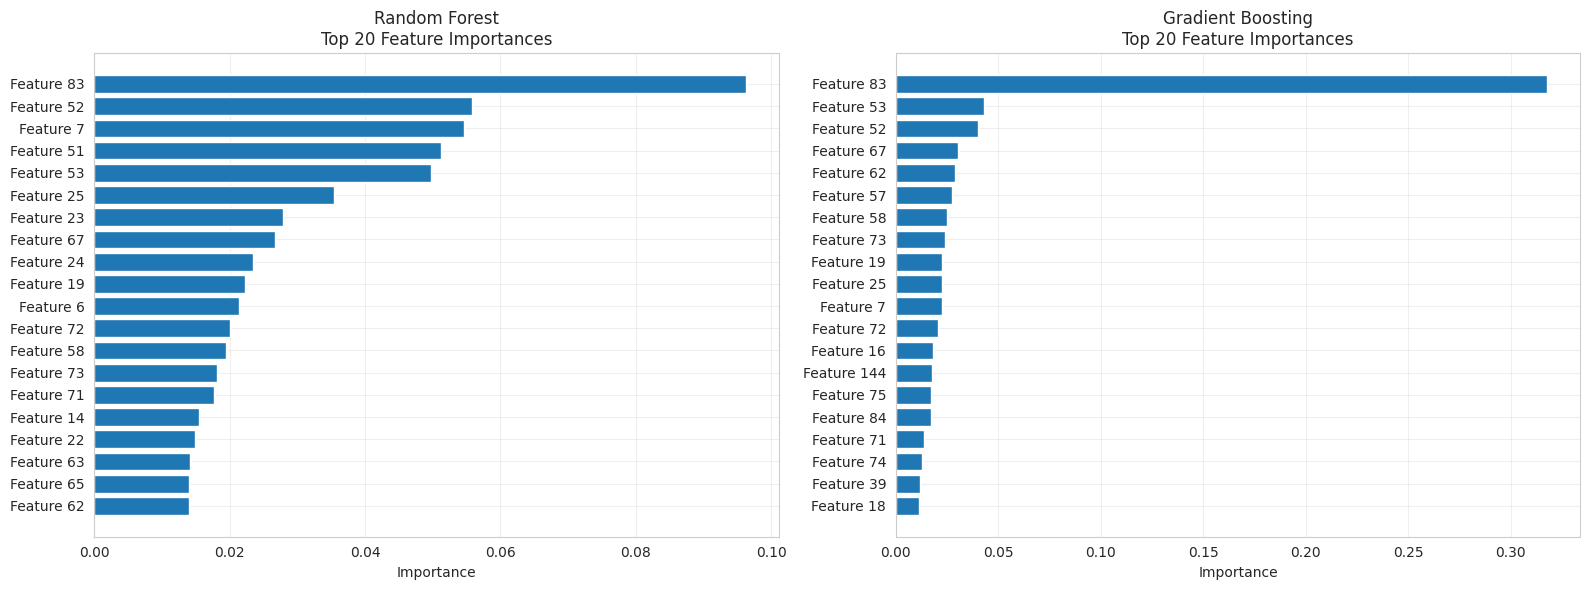

In [11]:
# Extract feature importance for tree-based models
tree_models = ['Random Forest', 'Gradient Boosting']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, name in enumerate(tree_models):
    if name in results:
        model = results[name]['model']
        classifier = model.named_steps['classifier']
        
        # Get feature names after preprocessing
        preprocessor = model.named_steps['preprocessor']
        
        # Get feature importances
        importances = classifier.feature_importances_
        
        # Get top 20 features
        indices = np.argsort(importances)[::-1][:20]
        top_importances = importances[indices]
        
        # Plot
        axes[idx].barh(range(20), top_importances[::-1])
        axes[idx].set_yticks(range(20))
        axes[idx].set_yticklabels([f'Feature {i}' for i in indices[::-1]])
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name}\nTop 20 Feature Importances')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Summary and Recommendations

In [12]:
# Print summary
print("\n" + "="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Best model by test F1
best_model = max(results.items(), key=lambda x: x[1]['test_metrics']['f1'])
print(f"\nBest model (by test F1): {best_model[0]}")
print(f"  Test F1 Score: {best_model[1]['test_metrics']['f1']:.4f}")
print(f"  Test ROC-AUC: {best_model[1]['test_metrics']['roc_auc']:.4f}")

# Models with significant overfitting
print("\nModels with significant overfitting (gap > 0.1):")
for name, res in results.items():
    gap = res['train_metrics']['f1'] - res['test_metrics']['f1']
    if gap > 0.1:
        print(f"  - {name}: gap = {gap:.4f}")

# Fastest model
fastest_model = min(results.items(), key=lambda x: x[1]['train_time'])
print(f"\nFastest training: {fastest_model[0]}")
print(f"  Train time: {fastest_model[1]['train_time']:.3f}s")

# Recommendations
print("\nRecommendations:")
print("  1. Models with overfitting should be regularized further")
print("  2. Consider hyperparameter tuning using the validation set")
print("  3. SGDClassifier supports partial_fit for federated learning")
print("  4. Feature engineering may improve performance across all models")
print("="*80)


SUMMARY AND RECOMMENDATIONS

Best model (by test F1): Random Forest
  Test F1 Score: 0.6862
  Test ROC-AUC: 0.7877

Models with significant overfitting (gap > 0.1):

Fastest training: SGD Classifier
  Train time: 4.092s

Recommendations:
  1. Models with overfitting should be regularized further
  2. Consider hyperparameter tuning using the validation set
  3. SGDClassifier supports partial_fit for federated learning
  4. Feature engineering may improve performance across all models
